In [72]:
from IPython.core.display import display, HTML
display(HTML("<style>.jp-OutputArea {max-height: 10000px;} .jp-OutputArea-scroll {max-height: 10000px !important;} </style>"))


/var/folders/gs/tsjxs_tx6rgb74l1zq_6rs0r0000gn/T/ipykernel_15282/154448484.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [73]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt


In [74]:
def portfolio_cost(z, mu, sigma, q):
    """
    Classical Markowitz-style portfolio cost (Eq. (1) in the paper):

        F(z) = q * sum_{i,j} z_i z_j sigma_{ij}
               - (1 - q) * sum_i z_i mu_i
    """
    z = np.asarray(z, dtype=float)
    mu = np.asarray(mu, dtype=float)
    sigma = np.asarray(sigma, dtype=float)

    risk_term = q * z @ sigma @ z
    return_term = (1.0 - q) * mu @ z

    return risk_term - return_term


def penalized_cost(z, mu, sigma, q, B, A):
    """
    Penalized cost F^(A)(z) = F(z) + A (sum_i z_i - B)^2 (Eq. (9)).
    """
    z = np.asarray(z, dtype=float)
    base = portfolio_cost(z, mu, sigma, q)
    penalty = A * (z.sum() - B)**2
    return base + penalty


In [75]:
def generate_random_portfolio_instance(n, seed=123):
    """
    Generate a random (mu, sigma) pair for testing.

    - mu: random expected returns in [0, 0.2]
    - sigma: random positive semidefinite covariance matrix
    """
    rng = np.random.default_rng(seed)
    mu = 0.2 * rng.random(n)

    # Make a random PSD covariance: sigma = A A^T, then scale
    A = rng.normal(size=(n, n))
    sigma = A @ A.T
    # Normalize variance levels a bit
    diag = np.diag(sigma)
    scale = 0.1 / np.mean(diag)
    sigma *= scale

    return mu, sigma


In [76]:
def detailed_bruteforce_stats(mu, sigma, q, B, A):
    """
    Safe version: handles edge cases where feasible or infeasible sets might be empty.
    """
    n = len(mu)
    feasible_F = []
    infeasible_F = []
    z_feasible = []
    z_infeasible = []

    for bits in product([0, 1], repeat=n):
        z = np.array(bits, dtype=int)
        if z.sum() == B:
            F_val = portfolio_cost(z, mu, sigma, q)
            feasible_F.append(F_val)
            z_feasible.append(z)
        else:
            F_pen = penalized_cost(z, mu, sigma, q, B, A)
            infeasible_F.append(F_pen)
            z_infeasible.append(z)

    if len(feasible_F) == 0:
        raise ValueError("No feasible states found (check B vs n).")

    if len(infeasible_F) == 0:
        # This is weird but let's fail gracefully and let caller decide to skip
        raise ValueError("No infeasible states found; penalty update not meaningful.")

    feasible_F = np.array(feasible_F)
    infeasible_F = np.array(infeasible_F)

    F_min = feasible_F.min()
    F_max = feasible_F.max()
    F_mean = feasible_F.mean()

    idx_nf_star = np.argmin(infeasible_F)
    F_nf_min = infeasible_F[idx_nf_star]
    z_nf_star = z_infeasible[idx_nf_star]

    return {
        "F_min": F_min,
        "F_max": F_max,
        "F_mean": F_mean,
        "F_nf_min": F_nf_min,
        "z_nf_star": z_nf_star,
        "feasible_costs": feasible_F,
        "infeasible_costs": infeasible_F,
        "z_feasible": z_feasible,
        "z_infeasible": z_infeasible,
    }


def one_step_A_update(mu, sigma, q, B, A0):
    """
    Safe wrapper around the ΔA update.
    Returns:
        A_new, stats, delta_A

    May raise ValueError if the instance is degenerate (we'll catch that upstream).
    """
    stats = detailed_bruteforce_stats(mu, sigma, q, B, A0)
    F_min = stats["F_min"]
    F_mean = stats["F_mean"]
    z_nf_star = stats["z_nf_star"]

    # ΔA formula (Eq. 13)
    delta_A = penalty_update_delta_A(mu, sigma, q, B, A0, z_nf_star, F_min, F_mean)

    # We don't want to decrease A, so clip at 0
    A_new = A0 + max(0.0, delta_A)

    return A_new, stats, delta_A



In [77]:
def penalty_update_delta_A(mu, sigma, q, B, A, z_star, F_min, F_mean):
    """
    Compute ΔA from Eq. (13):

        ΔA = [ 0.5 (F_min + F_mean) - F^(A)(z_star) ] / (sum_i z*_i - B)^2

    where:
      - F_min   = min F(z) over feasible z
      - F_mean  = mean F(z) over feasible z
      - z_star  = infeasible state achieving F_nf_min at current A

    We assume z_star is infeasible (sum z_i != B).
    """
    z_star = np.asarray(z_star, dtype=int)
    numerator = 0.5 * (F_min + F_mean) - penalized_cost(z_star, mu, sigma, q, B, A)
    denom = (z_star.sum() - B)**2
    if denom == 0:
        raise ValueError("z_star must be infeasible: sum(z_star) != B.")
    return numerator / denom


def one_step_A_update(mu, sigma, q, B, A0):
    """
    Perform a single ΔA update according to Eq. (13) in the paper.

    Returns:
        A_new, stats, delta_A
    """
    stats = detailed_bruteforce_stats(mu, sigma, q, B, A0)
    F_min = stats["F_min"]
    F_mean = stats["F_mean"]
    z_nf_star = stats["z_nf_star"]

    delta_A = penalty_update_delta_A(mu, sigma, q, B, A0, z_nf_star, F_min, F_mean)

    # We don't want to decrease A, so clip at 0
    A_new = A0 + max(0.0, delta_A)

    return A_new, stats, delta_A


In [78]:
def find_empirical_A_min(mu, sigma, q, B, A_grid):
    """
    For each A in A_grid, find the global minimum of F^(A)(z) over all z.
    Return the smallest A for which the argmin z is feasible (sum z_i = B).

    If none in the grid works, return (None, None).
    """
    n = len(mu)

    def global_min_config(A):
        best_val = None
        best_z = None
        for bits in product([0, 1], repeat=n):
            z = np.array(bits, dtype=int)
            F_pen = penalized_cost(z, mu, sigma, q, B, A)
            if best_val is None or F_pen < best_val:
                best_val = F_pen
                best_z = z
        return best_z, best_val

    A_min_emp = None
    z_at_min_emp = None

    for A in A_grid:
        z_star, F_star = global_min_config(A)
        if z_star.sum() == B:
            A_min_emp = A
            z_at_min_emp = z_star
            break

    return A_min_emp, z_at_min_emp


In [84]:
def analyze_penalty_bound(
    n_list=(4, 6, 8, 10, 12, 15),
    num_instances=20,
    q=1.0/3.0,
    B_frac=0.5,
    A0=0.0,
    A_max=20.0,
    A_step=0.001,
    seed_base=1234,
):
    """
    For each n in n_list:

      - generate num_instances random portfolio instances
      - for each instance:
          * compute one-step A_new (theoretical)
          * compute empirical A_min (grid search)
      - skip degenerate cases safely
      - plot results safely
    """
    results = {}

    for n in n_list:
        B = int(round(B_frac * n))
        A_grid = np.arange(0.0, A_max + 1e-9, A_step)

        A_theory_list = []
        A_emp_list = []

        print(f"\n=== Analyzing A-bound for n={n}, B={B} ===")

        for inst in range(num_instances):

            # Generate random instance
            mu, sigma = generate_random_portfolio_instance(
                n, seed=seed_base + 10 * n + inst
            )

            # Try A-update (theoretical)
            try:
                A_new, stats, delta_A = one_step_A_update(mu, sigma, q, B, A0)
            except Exception as e:
                print(f"  Instance {inst}: SKIPPED (A-update failed: {e})")
                continue

            # Try empirical A_min
            A_min_emp, z_at_min_emp = find_empirical_A_min(
                mu, sigma, q, B, A_grid
            )

            if A_min_emp is None:
                print(
                    f"  Instance {inst}: SKIPPED (no A in [0, {A_max}] gives feasible ground state)"
                )
                continue

            print(
                f"  Instance {inst}: A_new(theory)={A_new:.3f}, A_min(emp)={A_min_emp:.3f}"
            )

            A_theory_list.append(A_new)
            A_emp_list.append(A_min_emp)

        # Convert lists → arrays
        if len(A_theory_list) == 0:
            print(f"No valid instances for n={n}. Skipping plots.")
            continue

        A_theory = np.array(A_theory_list)
        A_emp = np.array(A_emp_list)

        results[n] = {
            "A_theory": A_theory,
            "A_emp": A_emp,
        }

        # ================================================
        #  PLOTS
        # ================================================

        # ---- 1) Scatter plot: A_emp vs A_theory ----
        plt.figure(figsize=(6, 5))
        plt.scatter(A_emp, A_theory)
        max_val = max(A_emp.max(), A_theory.max()) * 1.05
        plt.plot([0, max_val], [0, max_val], linestyle="--", label="y = x")
        plt.xlabel("Empirical A_min (grid search)")
        plt.ylabel("Theoretical A_new (one-step update)")
        plt.title(f"Penalty bound comparison for n={n}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ---- 2) Histogram of ratio A_theory / A_emp ----
        ratio = A_theory / A_emp
        ratio_clean = ratio[np.isfinite(ratio)]  # remove inf/nan

        if len(ratio_clean) == 0:
            print(f"No finite ratios for n={n}. Skipping histogram.")
        else:
            plt.figure(figsize=(6, 4))
            plt.hist(ratio_clean, bins=10, edgecolor="black")
            plt.xlabel("A_theory / A_emp")
            plt.ylabel("Count")
            plt.title(f"Ratio of theoretical to empirical A (n={n})")
            plt.tight_layout()
            plt.show()

    return results



=== Analyzing A-bound for n=4, B=2 ===
  Instance 0: A_new(theory)=0.016, A_min(emp)=0.027
  Instance 1: A_new(theory)=0.080, A_min(emp)=0.044
  Instance 2: A_new(theory)=0.034, A_min(emp)=0.006
  Instance 3: A_new(theory)=0.124, A_min(emp)=0.093
  Instance 4: A_new(theory)=0.028, A_min(emp)=0.000
  Instance 5: A_new(theory)=0.069, A_min(emp)=0.043
  Instance 6: A_new(theory)=0.056, A_min(emp)=0.111
  Instance 7: A_new(theory)=0.040, A_min(emp)=0.088
  Instance 8: A_new(theory)=0.026, A_min(emp)=0.087
  Instance 9: A_new(theory)=0.007, A_min(emp)=0.000
  Instance 10: A_new(theory)=0.046, A_min(emp)=0.020
  Instance 11: A_new(theory)=0.035, A_min(emp)=0.004
  Instance 12: A_new(theory)=0.053, A_min(emp)=0.009
  Instance 13: A_new(theory)=0.066, A_min(emp)=0.002
  Instance 14: A_new(theory)=0.022, A_min(emp)=0.042
  Instance 15: A_new(theory)=0.046, A_min(emp)=0.000
  Instance 16: A_new(theory)=0.031, A_min(emp)=0.081
  Instance 17: A_new(theory)=0.056, A_min(emp)=0.013
  Instance 18: A

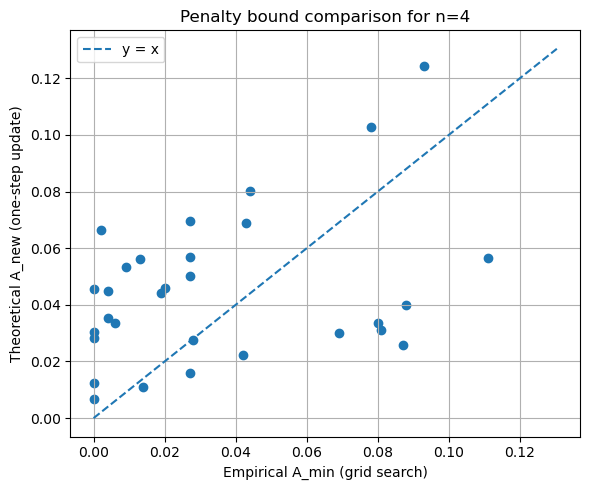

/var/folders/gs/tsjxs_tx6rgb74l1zq_6rs0r0000gn/T/ipykernel_15282/332590948.py:95: RuntimeWarning: divide by zero encountered in divide
  ratio = A_theory / A_emp


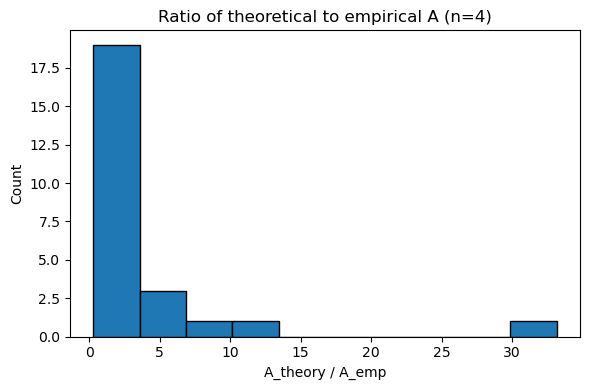


=== Analyzing A-bound for n=6, B=3 ===
  Instance 0: A_new(theory)=0.020, A_min(emp)=0.031
  Instance 1: A_new(theory)=0.025, A_min(emp)=0.034
  Instance 2: A_new(theory)=0.045, A_min(emp)=0.006
  Instance 3: A_new(theory)=0.022, A_min(emp)=0.001
  Instance 4: A_new(theory)=0.116, A_min(emp)=0.052
  Instance 5: A_new(theory)=0.031, A_min(emp)=0.055
  Instance 6: A_new(theory)=0.081, A_min(emp)=0.007
  Instance 7: A_new(theory)=0.084, A_min(emp)=0.014
  Instance 8: A_new(theory)=0.026, A_min(emp)=0.012
  Instance 9: A_new(theory)=0.015, A_min(emp)=0.000
  Instance 10: A_new(theory)=0.047, A_min(emp)=0.081
  Instance 11: A_new(theory)=0.063, A_min(emp)=0.011
  Instance 12: A_new(theory)=0.022, A_min(emp)=0.017
  Instance 13: A_new(theory)=0.020, A_min(emp)=0.031
  Instance 14: A_new(theory)=0.043, A_min(emp)=0.000
  Instance 15: A_new(theory)=0.040, A_min(emp)=0.000
  Instance 16: A_new(theory)=0.094, A_min(emp)=0.023
  Instance 17: A_new(theory)=0.039, A_min(emp)=0.065
  Instance 18: A

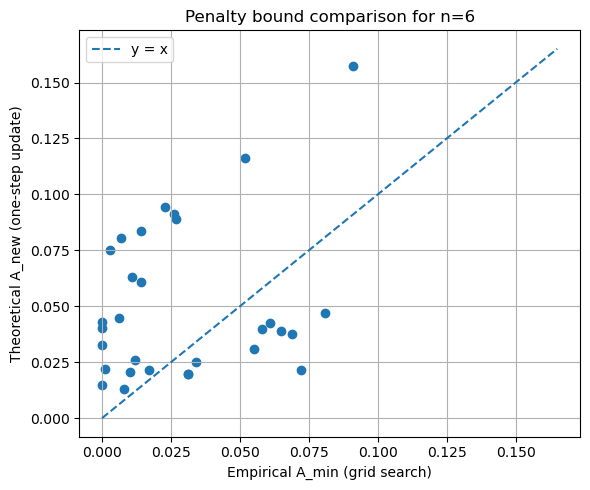

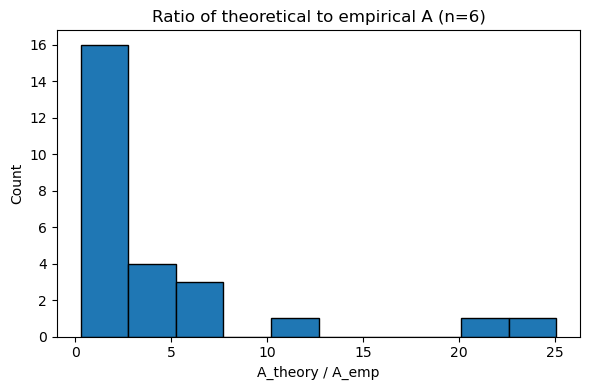


=== Analyzing A-bound for n=8, B=4 ===
  Instance 0: A_new(theory)=0.019, A_min(emp)=0.031
  Instance 1: A_new(theory)=0.034, A_min(emp)=0.028
  Instance 2: A_new(theory)=0.067, A_min(emp)=0.000
  Instance 3: A_new(theory)=0.043, A_min(emp)=0.043
  Instance 4: A_new(theory)=0.018, A_min(emp)=0.007
  Instance 5: A_new(theory)=0.020, A_min(emp)=0.049
  Instance 6: A_new(theory)=0.035, A_min(emp)=0.038
  Instance 7: A_new(theory)=0.036, A_min(emp)=0.028
  Instance 8: A_new(theory)=0.029, A_min(emp)=0.023
  Instance 9: A_new(theory)=0.014, A_min(emp)=0.040
  Instance 10: A_new(theory)=0.041, A_min(emp)=0.046
  Instance 11: A_new(theory)=0.105, A_min(emp)=0.005
  Instance 12: A_new(theory)=0.057, A_min(emp)=0.086
  Instance 13: A_new(theory)=0.027, A_min(emp)=0.009
  Instance 14: A_new(theory)=0.012, A_min(emp)=0.011
  Instance 15: A_new(theory)=0.033, A_min(emp)=0.025
  Instance 16: A_new(theory)=0.017, A_min(emp)=0.048
  Instance 17: A_new(theory)=0.018, A_min(emp)=0.029
  Instance 18: A

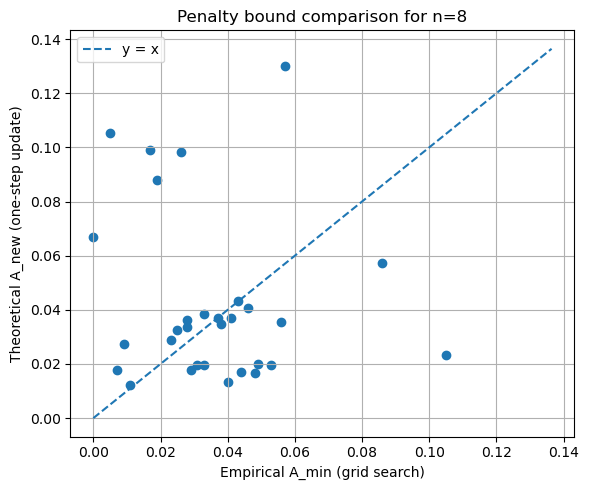

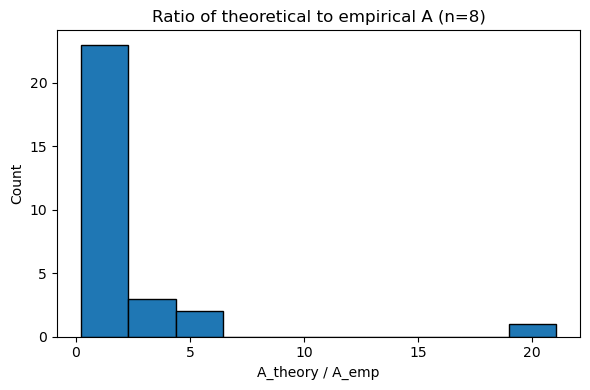


=== Analyzing A-bound for n=10, B=5 ===
  Instance 0: A_new(theory)=0.041, A_min(emp)=0.033
  Instance 1: A_new(theory)=0.016, A_min(emp)=0.065
  Instance 2: A_new(theory)=0.017, A_min(emp)=0.069
  Instance 3: A_new(theory)=0.043, A_min(emp)=0.044
  Instance 4: A_new(theory)=0.014, A_min(emp)=0.028
  Instance 5: A_new(theory)=0.036, A_min(emp)=0.033
  Instance 6: A_new(theory)=0.019, A_min(emp)=0.032
  Instance 7: A_new(theory)=0.102, A_min(emp)=0.000
  Instance 8: A_new(theory)=0.027, A_min(emp)=0.064
  Instance 9: A_new(theory)=0.014, A_min(emp)=0.065
  Instance 10: A_new(theory)=0.041, A_min(emp)=0.042
  Instance 11: A_new(theory)=0.026, A_min(emp)=0.063
  Instance 12: A_new(theory)=0.040, A_min(emp)=0.036
  Instance 13: A_new(theory)=0.038, A_min(emp)=0.043
  Instance 14: A_new(theory)=0.029, A_min(emp)=0.084
  Instance 15: A_new(theory)=0.010, A_min(emp)=0.034
  Instance 16: A_new(theory)=0.100, A_min(emp)=0.005
  Instance 17: A_new(theory)=0.007, A_min(emp)=0.060
  Instance 18: 

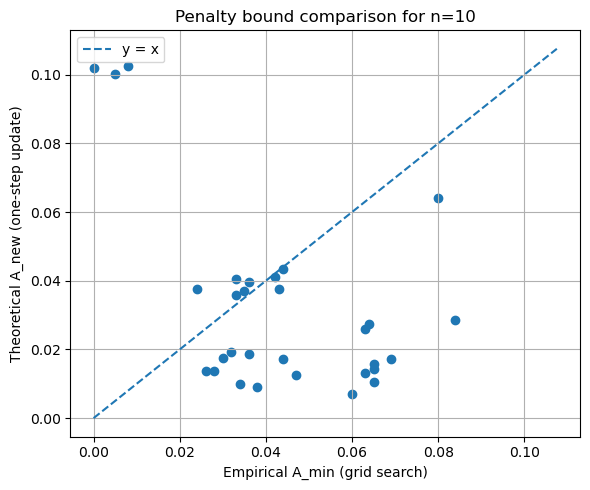

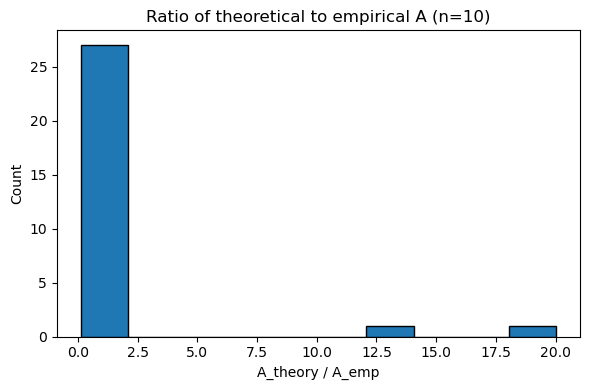


=== Analyzing A-bound for n=12, B=6 ===
  Instance 0: A_new(theory)=0.016, A_min(emp)=0.047
  Instance 1: A_new(theory)=0.013, A_min(emp)=0.073
  Instance 2: A_new(theory)=0.029, A_min(emp)=0.048
  Instance 3: A_new(theory)=0.014, A_min(emp)=0.019
  Instance 4: A_new(theory)=0.112, A_min(emp)=0.000
  Instance 5: A_new(theory)=0.065, A_min(emp)=0.079
  Instance 6: A_new(theory)=0.018, A_min(emp)=0.018
  Instance 7: A_new(theory)=0.023, A_min(emp)=0.057
  Instance 8: A_new(theory)=0.050, A_min(emp)=0.035
  Instance 9: A_new(theory)=0.005, A_min(emp)=0.015
  Instance 10: A_new(theory)=0.015, A_min(emp)=0.076
  Instance 11: A_new(theory)=0.022, A_min(emp)=0.046
  Instance 12: A_new(theory)=0.125, A_min(emp)=0.000
  Instance 13: A_new(theory)=0.045, A_min(emp)=0.028
  Instance 14: A_new(theory)=0.020, A_min(emp)=0.056
  Instance 15: A_new(theory)=0.016, A_min(emp)=0.051
  Instance 16: A_new(theory)=0.029, A_min(emp)=0.003
  Instance 17: A_new(theory)=0.043, A_min(emp)=0.029
  Instance 18: 

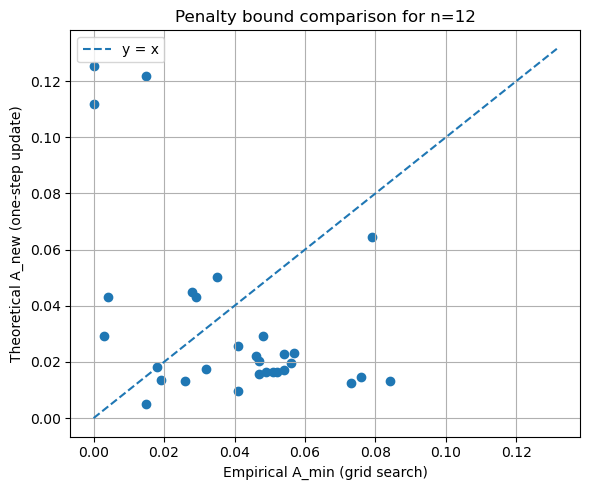

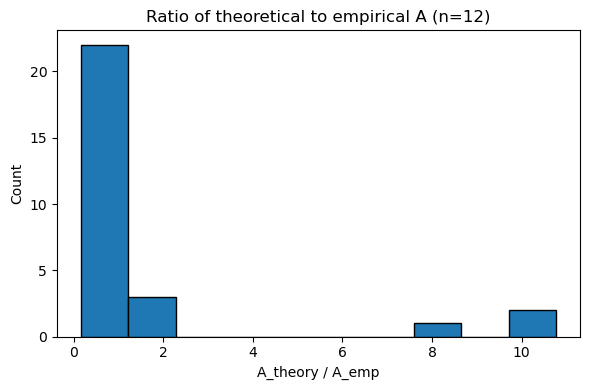


=== Analyzing A-bound for n=15, B=8 ===
  Instance 0: A_new(theory)=0.058, A_min(emp)=0.024
  Instance 1: A_new(theory)=0.016, A_min(emp)=0.043
  Instance 2: A_new(theory)=0.018, A_min(emp)=0.051
  Instance 3: A_new(theory)=0.169, A_min(emp)=0.008
  Instance 4: A_new(theory)=0.007, A_min(emp)=0.008
  Instance 5: A_new(theory)=0.010, A_min(emp)=0.065
  Instance 6: A_new(theory)=0.050, A_min(emp)=0.038
  Instance 7: A_new(theory)=0.049, A_min(emp)=0.022
  Instance 8: A_new(theory)=0.026, A_min(emp)=0.028
  Instance 9: A_new(theory)=0.240, A_min(emp)=0.030
  Instance 10: A_new(theory)=0.184, A_min(emp)=0.000
  Instance 11: A_new(theory)=0.009, A_min(emp)=0.055
  Instance 12: A_new(theory)=0.039, A_min(emp)=0.015
  Instance 13: A_new(theory)=0.015, A_min(emp)=0.048
  Instance 14: A_new(theory)=0.137, A_min(emp)=0.009
  Instance 15: A_new(theory)=0.016, A_min(emp)=0.072
  Instance 16: A_new(theory)=0.010, A_min(emp)=0.039
  Instance 17: A_new(theory)=0.012, A_min(emp)=0.061
  Instance 18: 

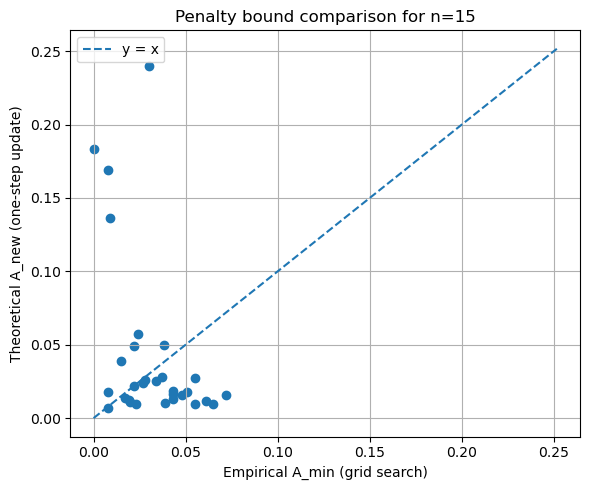

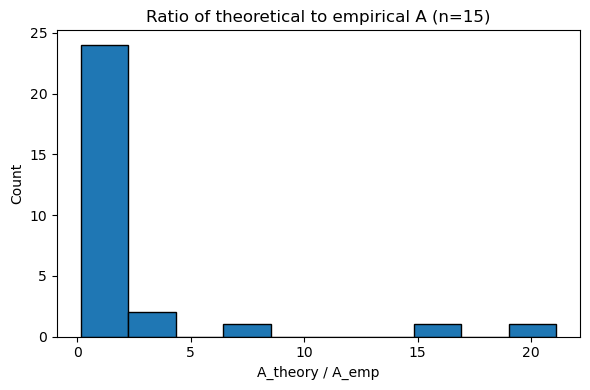

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

In [85]:
penalty_results = analyze_penalty_bound(
    n_list=(4, 6, 8, 10, 12, 15),
    num_instances=30,
    q=1.0/3.0,
    B_frac=0.5,
    A0=0.0,
    A_max=20.0,
    A_step=0.001,
    seed_base=1234,
)
plt.figure(figsize=(14, 10))   # make it big


In [86]:
for n in penalty_results:
    A_th = penalty_results[n]["A_theory"]
    A_emp = penalty_results[n]["A_emp"]
    ratio = A_th / A_emp
    print(f"n={n}: mean ratio = {np.mean(ratio[np.isfinite(ratio)]):.2f}")


n=4: mean ratio = 3.67
n=6: mean ratio = 4.24
n=8: mean ratio = 2.08
n=10: mean ratio = 1.68
n=12: mean ratio = 1.53
n=15: mean ratio = 2.27


/var/folders/gs/tsjxs_tx6rgb74l1zq_6rs0r0000gn/T/ipykernel_15282/537932828.py:4: RuntimeWarning: divide by zero encountered in divide
  ratio = A_th / A_emp


In [87]:
for n in (4, 6, 8, 10, 12, 15):
    print(f"\n=== n = {n} ===")
    A_th = penalty_results[n]["A_theory"]
    A_emp = penalty_results[n]["A_emp"]
    for i in range(min(5, len(A_th))):
        print(f"instance {i}: A_theory = {A_th[i]:.3f}, A_emp = {A_emp[i]:.3f}, ratio = {A_th[i]/A_emp[i]:.3f}")



=== n = 4 ===
instance 0: A_theory = 0.016, A_emp = 0.027, ratio = 0.592
instance 1: A_theory = 0.080, A_emp = 0.044, ratio = 1.819
instance 2: A_theory = 0.034, A_emp = 0.006, ratio = 5.604
instance 3: A_theory = 0.124, A_emp = 0.093, ratio = 1.335
instance 4: A_theory = 0.028, A_emp = 0.000, ratio = inf

=== n = 6 ===
instance 0: A_theory = 0.020, A_emp = 0.031, ratio = 0.639
instance 1: A_theory = 0.025, A_emp = 0.034, ratio = 0.734
instance 2: A_theory = 0.045, A_emp = 0.006, ratio = 7.495
instance 3: A_theory = 0.022, A_emp = 0.001, ratio = 22.066
instance 4: A_theory = 0.116, A_emp = 0.052, ratio = 2.235

=== n = 8 ===
instance 0: A_theory = 0.019, A_emp = 0.031, ratio = 0.628
instance 1: A_theory = 0.034, A_emp = 0.028, ratio = 1.205
instance 2: A_theory = 0.067, A_emp = 0.000, ratio = inf
instance 3: A_theory = 0.043, A_emp = 0.043, ratio = 1.007
instance 4: A_theory = 0.018, A_emp = 0.007, ratio = 2.545

=== n = 10 ===
instance 0: A_theory = 0.041, A_emp = 0.033, ratio = 1.23

/var/folders/gs/tsjxs_tx6rgb74l1zq_6rs0r0000gn/T/ipykernel_15282/1947971310.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"instance {i}: A_theory = {A_th[i]:.3f}, A_emp = {A_emp[i]:.3f}, ratio = {A_th[i]/A_emp[i]:.3f}")


/var/folders/gs/tsjxs_tx6rgb74l1zq_6rs0r0000gn/T/ipykernel_15282/4123294258.py:10: RuntimeWarning: divide by zero encountered in divide
  ratio = A_th / A_emp


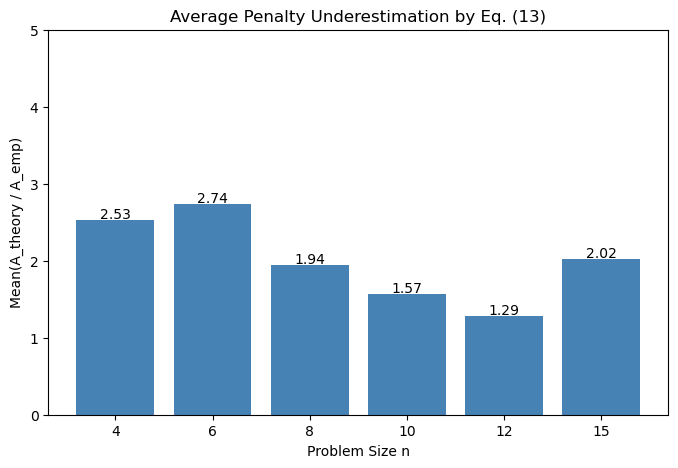

In [83]:
import numpy as np
import matplotlib.pyplot as plt

n_values = sorted(penalty_results.keys())
mean_ratios = []

for n in n_values:
    A_th = penalty_results[n]["A_theory"]
    A_emp = penalty_results[n]["A_emp"]
    ratio = A_th / A_emp
    mean_ratio = np.mean(ratio[np.isfinite(ratio)])
    mean_ratios.append(mean_ratio)

plt.figure(figsize=(8,5))
plt.bar([str(n) for n in n_values], mean_ratios, color='steelblue')

plt.xlabel("Problem Size n")
plt.ylabel("Mean(A_theory / A_emp)")
plt.title("Average Penalty Underestimation by Eq. (13)")
plt.ylim(0, 5.0)

for i, v in enumerate(mean_ratios):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.show()


In [93]:
import numpy as np

n_values = sorted(penalty_results.keys())
mean_ratios_excl0 = []

for n in n_values:
    A_th = penalty_results[n]["A_theory"]
    A_emp = penalty_results[n]["A_emp"]

    # Compute the full ratio array
    ratio = A_th / A_emp

    # Remove instance 0
    ratio_excl0 = ratio[1:]

    # Remove infinities and NaNs
    ratio_excl0 = ratio_excl0[np.isfinite(ratio_excl0)]

    # Compute mean using the remaining instances
    mean_ratio = np.mean(ratio_excl0)

    mean_ratios_excl0.append(mean_ratio)


/var/folders/gs/tsjxs_tx6rgb74l1zq_6rs0r0000gn/T/ipykernel_15282/182344913.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio = A_th / A_emp


/var/folders/gs/tsjxs_tx6rgb74l1zq_6rs0r0000gn/T/ipykernel_15282/1129210325.py:12: RuntimeWarning: divide by zero encountered in divide
  ratio = A_th / A_emp


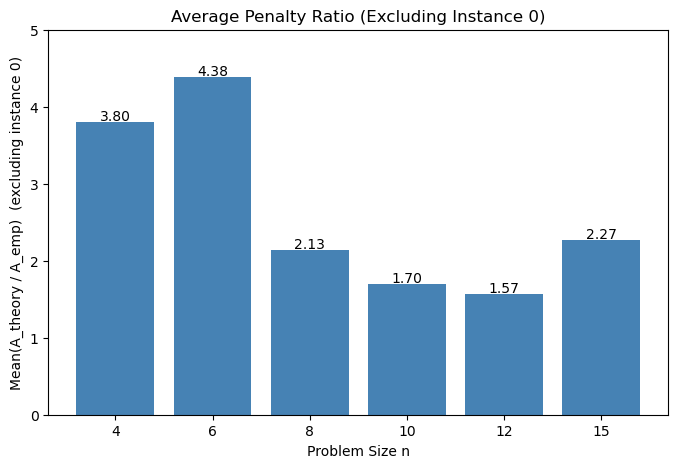

In [96]:
import numpy as np
import matplotlib.pyplot as plt

n_values = sorted(penalty_results.keys())
mean_ratios_excl0 = []

for n in n_values:
    A_th = penalty_results[n]["A_theory"]
    A_emp = penalty_results[n]["A_emp"]

    # Compute full ratios
    ratio = A_th / A_emp

    # Remove instance 0
    ratio_excl0 = ratio[1:]

    # Remove infinities / NaNs
    ratio_excl0 = ratio_excl0[np.isfinite(ratio_excl0)]

    # Compute mean
    mean_ratio = np.mean(ratio_excl0)
    mean_ratios_excl0.append(mean_ratio)

plt.figure(figsize=(8,5))
plt.bar([str(n) for n in n_values], mean_ratios_excl0, color='steelblue')

plt.xlabel("Problem Size n")
plt.ylabel("Mean(A_theory / A_emp)  (excluding instance 0)")
plt.title("Average Penalty Ratio (Excluding Instance 0)")
plt.ylim(0, 5.0)

# Add labels above each bar
for i, v in enumerate(mean_ratios_excl0):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')


/var/folders/gs/tsjxs_tx6rgb74l1zq_6rs0r0000gn/T/ipykernel_15282/2848658730.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio = A_th / A_emp


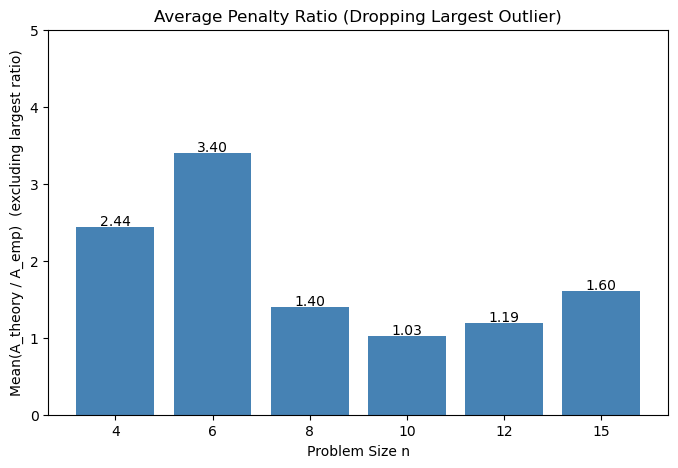

In [98]:
import numpy as np
import matplotlib.pyplot as plt

n_values = sorted(penalty_results.keys())
mean_ratios_no_max = []

for n in n_values:
    A_th = penalty_results[n]["A_theory"]
    A_emp = penalty_results[n]["A_emp"]

    ratio = A_th / A_emp

    # keep only finite ratios
    finite_mask = np.isfinite(ratio)
    ratio_finite = ratio[finite_mask]

    # if there is at least 2 finite values, drop the largest one
    if len(ratio_finite) > 1:
        idx_max = np.argmax(ratio_finite)
        ratio_wo_max = np.delete(ratio_finite, idx_max)
    else:
        ratio_wo_max = ratio_finite  # nothing to drop

    mean_ratio = np.mean(ratio_wo_max)
    mean_ratios_no_max.append(mean_ratio)

# --- plotting ---
plt.figure(figsize=(8,5))
plt.bar([str(n) for n in n_values], mean_ratios_no_max, color='steelblue')

plt.xlabel("Problem Size n")
plt.ylabel("Mean(A_theory / A_emp)  (excluding largest ratio)")
plt.title("Average Penalty Ratio (Dropping Largest Outlier)")
plt.ylim(0, 5.0)

for i, v in enumerate(mean_ratios_no_max):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.show()


n=4: mean excluding top 10 = 0.889, original mean = 3.670
n=6: mean excluding top 10 = 1.067, original mean = 4.238
n=8: mean excluding top 10 = 0.705, original mean = 2.082
n=10: mean excluding top 10 = 0.374, original mean = 1.683
n=12: mean excluding top 10 = 0.360, original mean = 1.529
n=15: mean excluding top 10 = 0.472, original mean = 2.274


/var/folders/gs/tsjxs_tx6rgb74l1zq_6rs0r0000gn/T/ipykernel_15282/2523157076.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio = A_th / A_emp


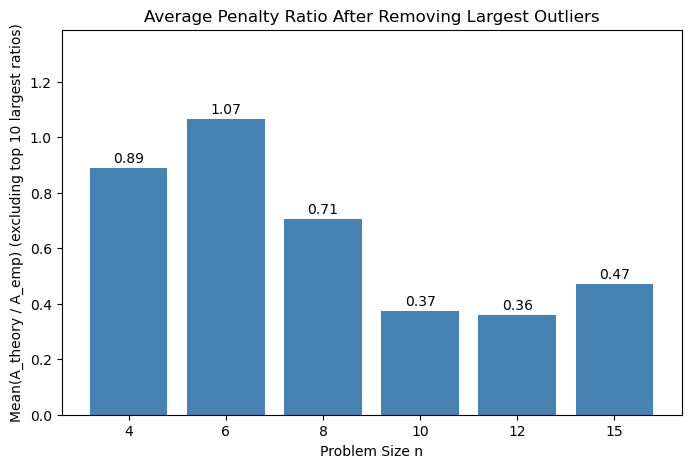

In [99]:
import numpy as np
import matplotlib.pyplot as plt

n_values = sorted(penalty_results.keys())
mean_ratios_excl10 = []

for n in n_values:
    A_th = penalty_results[n]["A_theory"]
    A_emp = penalty_results[n]["A_emp"]

    ratio = A_th / A_emp
    ratio = ratio[np.isfinite(ratio)]  # remove inf

    # Sort ratios ascending
    sorted_ratios = np.sort(ratio)

    # Remove the 10 largest values (or fewer if not enough instances)
    trimmed = sorted_ratios[:-10] if len(sorted_ratios) > 10 else sorted_ratios

    # Compute mean of remaining values
    mean_trimmed = np.mean(trimmed)
    mean_ratios_excl10.append(mean_trimmed)

    print(f"n={n}: mean excluding top 10 = {mean_trimmed:.3f}, original mean = {np.mean(sorted_ratios):.3f}")

# Plot
plt.figure(figsize=(8,5))
plt.bar([str(n) for n in n_values], mean_ratios_excl10, color='steelblue')

plt.xlabel("Problem Size n")
plt.ylabel("Mean(A_theory / A_emp) (excluding top 10 largest ratios)")
plt.title("Average Penalty Ratio After Removing Largest Outliers")

for i, v in enumerate(mean_ratios_excl10):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.ylim(0, max(mean_ratios_excl10)*1.3)
plt.show()


n=4: trimmed mean (top 10 removed) = 0.8889, original mean = 3.6701
n=6: trimmed mean (top 10 removed) = 1.0673, original mean = 4.2375
n=8: trimmed mean (top 10 removed) = 0.7052, original mean = 2.0819
n=10: trimmed mean (top 10 removed) = 0.3736, original mean = 1.6829
n=12: trimmed mean (top 10 removed) = 0.3597, original mean = 1.5294
n=15: trimmed mean (top 10 removed) = 0.4722, original mean = 2.2743


/var/folders/gs/tsjxs_tx6rgb74l1zq_6rs0r0000gn/T/ipykernel_15282/1606235352.py:12: RuntimeWarning: divide by zero encountered in divide
  ratio = A_th / A_emp


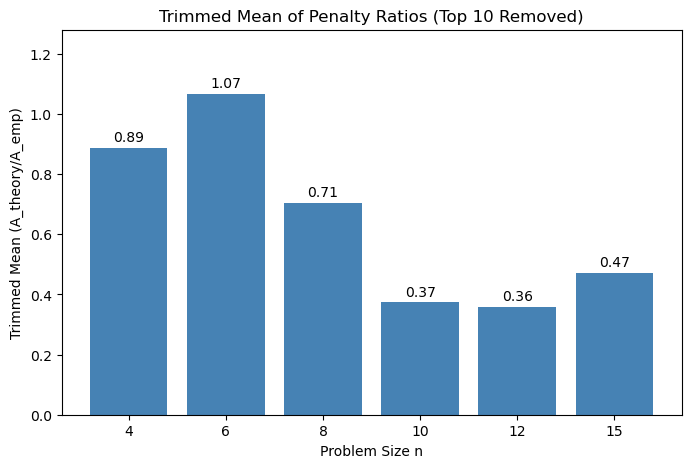

In [102]:
import numpy as np
import matplotlib.pyplot as plt

n_values = sorted(penalty_results.keys())
trimmed_means = []

for n in n_values:
    A_th = penalty_results[n]["A_theory"]
    A_emp = penalty_results[n]["A_emp"]

    # Compute ratios and remove infinities / NaNs
    ratio = A_th / A_emp
    ratio = ratio[np.isfinite(ratio)]

    # Sort ratios
    sorted_ratios = np.sort(ratio)

    # Remove the top 10 largest ratios (or fewer if less than 10 values exist)
    if len(sorted_ratios) > 10:
        trimmed = sorted_ratios[:-10]
    else:
        trimmed = sorted_ratios  # no trimming possible

    trimmed_mean = np.mean(trimmed)
    trimmed_means.append(trimmed_mean)

    print(f"n={n}: trimmed mean (top 10 removed) = {trimmed_mean:.4f}, original mean = {np.mean(sorted_ratios):.4f}")

# ---- Optional bar plot ----
plt.figure(figsize=(8,5))
plt.bar([str(n) for n in n_values], trimmed_means, color='steelblue')

plt.xlabel("Problem Size n")
plt.ylabel("Trimmed Mean (A_theory/A_emp)")
plt.title("Trimmed Mean of Penalty Ratios (Top 10 Removed)")

for i, v in enumerate(trimmed_means):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.ylim(0, max(trimmed_means) * 1.2)
plt.show()


n=4: geometric mean = 1.6129, arithmetic mean = 3.6701
n=6: geometric mean = 1.9848, arithmetic mean = 4.2375
n=8: geometric mean = 1.0935, arithmetic mean = 2.0819
n=10: geometric mean = 0.6047, arithmetic mean = 1.6829
n=12: geometric mean = 0.6381, arithmetic mean = 1.5294
n=15: geometric mean = 0.8277, arithmetic mean = 2.2743


/var/folders/gs/tsjxs_tx6rgb74l1zq_6rs0r0000gn/T/ipykernel_15282/2706586066.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio = A_th / A_emp


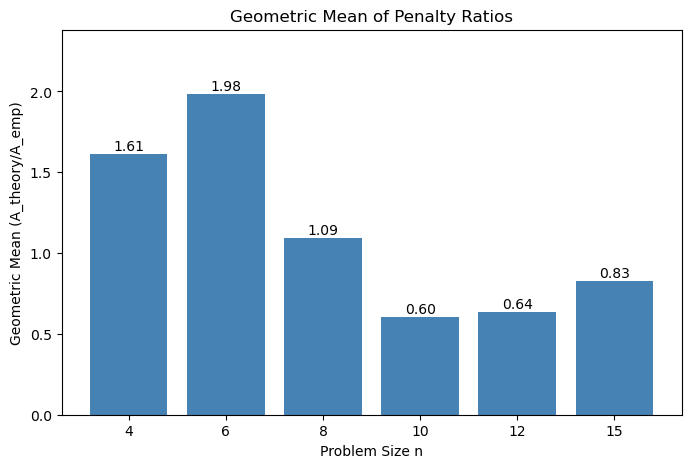

In [103]:
import numpy as np
import matplotlib.pyplot as plt

n_values = sorted(penalty_results.keys())
geom_means = []

for n in n_values:
    A_th = penalty_results[n]["A_theory"]
    A_emp = penalty_results[n]["A_emp"]

    ratio = A_th / A_emp

    # keep only positive finite ratios
    valid = ratio[(ratio > 0) & np.isfinite(ratio)]

    # geometric mean
    geom_mean = np.exp(np.mean(np.log(valid)))
    geom_means.append(geom_mean)

    print(f"n={n}: geometric mean = {geom_mean:.4f}, arithmetic mean = {np.mean(valid):.4f}")

# ---- Optional bar plot ----
plt.figure(figsize=(8,5))
plt.bar([str(n) for n in n_values], geom_means, color='steelblue')

plt.xlabel("Problem Size n")
plt.ylabel("Geometric Mean (A_theory/A_emp)")
plt.title("Geometric Mean of Penalty Ratios")

for i, v in enumerate(geom_means):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.ylim(0, max(geom_means) * 1.2)
plt.show()
